Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 10 - Predicting Continuous Target Variables with Regression Analysis 
# 회귀분석에 의한 연속형 목표변수 예측 

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

Sebastian Raschka 
last updated: 2017-09-19 

CPython 3.5.3
IPython 6.2.0

numpy 1.13.1
pandas 0.20.1
matplotlib 2.0.2
sklearn 0.18.2
seaborn 0.8.0


### Overview

- [Introducing a simple linear regression model](#Introducing-a-simple-linear-regression-model2)
- [Exploring the Housing Dataset](#Exploring-the-Housing-Dataset)
  - [Visualizing the important characteristics of a dataset](#Visualizing-the-important-characteristics-of-a-dataset)
- [Implementing an ordinary least squares linear regression model](#Implementing-an-ordinary-least-squares-linear-regression-model)
  - [Solving regression for regression parameters with gradient descent](#Solving-regression-for-regression-parameters-with-gradient-descent)
  - [Estimating the coefficient of a regression model via scikit-learn](#Estimating-the-coefficient-of-a-regression-model-via-scikit-learn)
- [Fitting a robust regression model using RANSAC](#Fitting-a-robust-regression-model-using-RANSAC)
- [Evaluating the performance of linear regression models](#Evaluating-the-performance-of-linear-regression-models)
- [Using regularized methods for regression](#Using-regularized-methods-for-regression)
- [Turning a linear regression model into a curve - polynomial regression](#Turning-a-linear-regression-model-into-a-curve---polynomial-regression)
  - [Modeling nonlinear relationships in the Housing Dataset](#Modeling-nonlinear-relationships-in-the-Housing-Dataset)
  - [Dealing with nonlinear relationships using random forests](#Dealing-with-nonlinear-relationships-using-random-forests)
    - [Decision tree regression](#Decision-tree-regression)
    - [Random forest regression](#Random-forest-regression)
- [Summary](#Summary)

- 데이터의 탐색과 시각화 
- 선형회귀 모델의 구현을 위한 여러가지 방법 살펴보기 
- 이상치에 강건한 회귀 모델 훈련하기 
- 회귀 모델 평가와 일반적인 문제 진단 
- 비선형 데이터에 회귀 모델 피팅하기 


In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# 10.1 Introducing a simple linear regression model 
# 심플 선형회귀 모델 소개 

심플(단변량, univariate) 선형회귀의 목표는 단일 피처(설명변수 $x$)와 연속형 반응 값(목표변수 $y$) 간의 관계를 모델링하는 것이다. 
우리의 목표는 설명변수와 목표변수 간의 관계를 설명하기 위해 선형방정식의 가중치를 학습하여 훈련 데이터의 일부가 아니었던 새로운 설명변수의 반응을 예측하는 데 사용하는 것이다. 

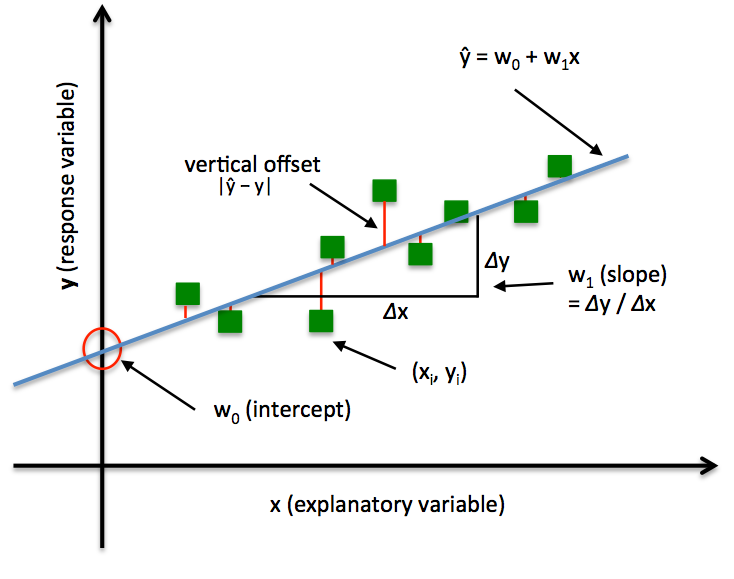

In [4]:
Image(filename='./images/10_01.png', width=500) 

최적-피팅 직선 역시 회귀선이라고 하며, 회귀선에서 샘플 관측치들까지의 수직선을 오프셋(offsets) 또는 잔차(residuals)라고 부른다(예측에 대한 오차). 

<br>
<br>

# 10.2 Exploring the Housing dataset 
# 하우징 데이터 탐색 

1978년에 해리슨 박사(D.Harrison)와 L.루빈펠트 박사(D.L.Rubinfeld)가 수집한 보스턴 외곽 집들에 대한 정보를 포함하고 있다. 

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
<pre>
1. CRIM      per capita crime rate by town 
             자치시별 1인당 범죄율
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft. 
             25,000평방피트를 초과하는 거주지역의 비율
3. INDUS     proportion of non-retail business acres per town 
             비소매상업지역이 점유하고 있는 토지의 비율 
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
             찰스강에 대한 더미 변수(강의 경계 위치이면 1, 아니면 0)
5. NOX       nitric oxides concentration (parts per 10 million) 
             10ppm당 일산화질산 농도 
6. RM        average number of rooms per dwelling 
             주택 1가구당 평균 방의 개수 
7. AGE       proportion of owner-occupied units built prior to 1940 
             1940년 이전에 걱축된 소유 주택의 비율 
8. DIS       weighted distances to five Boston employment centres 
             5개 보스턴 직업센터까지의 접근성 
9. RAD       index of accessibility to radial highways 
             방사형 고속도로까지의 접근성에 대한 지표 
10. TAX      full-value property-tax rate per $10,000 
             10,000달더당 재산세율 
11. PTRATIO  pupil-teacher ratio by town
             자치시별 학생/교사 비율 
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
             여기서 Bk는 자치시별 흑인 비율 
13. LSTAT    % lower status of the population 
             모집단의 하위계층의 비율(%) 
14. MEDV     Median value of owner-occupied homes in $1000's 
             본인 소유의 주택가격(중앙값) (단위: 1,000달러) 
</pre>

In [5]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<hr>

### Note:


If the link to the Housing dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/housing/housing.data](./../datasets/housing/housing.data).

Or you could fetch it via

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/housing/housing.data',
                  header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

<br>
<br>

## 10.2.1 Visualizing the important characteristics of a dataset 
## 데이터의 주요 특성 시각화 

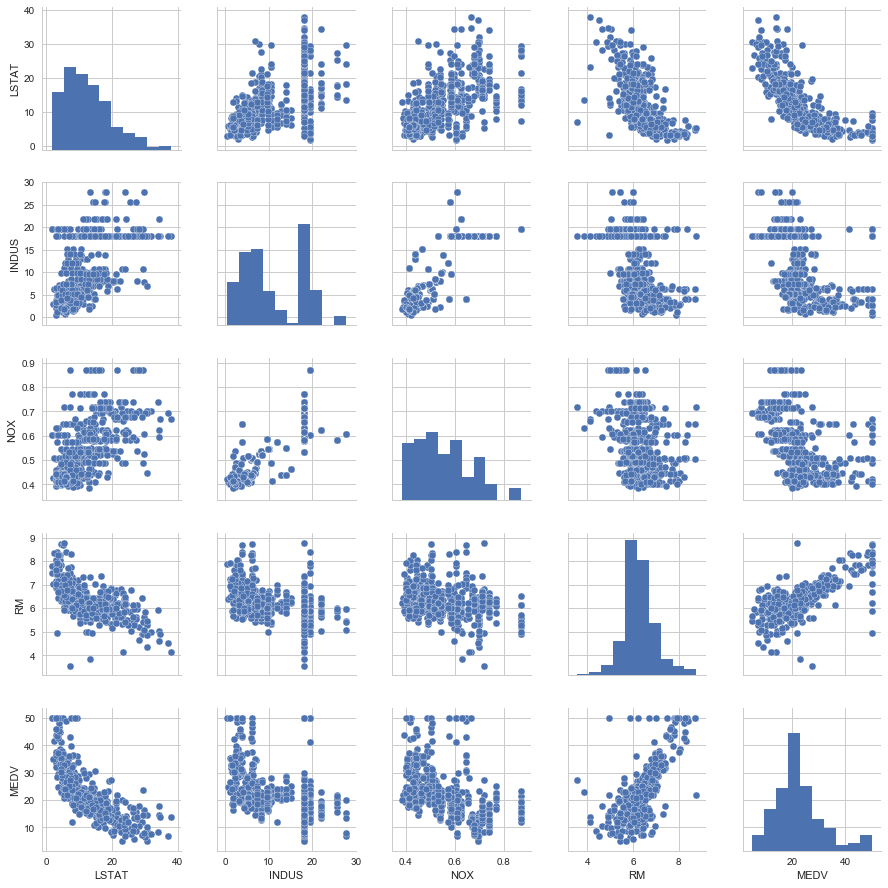

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

피처 간 선형관계를 수량화하기 위해 이제 상관행렬을 생성하려고 한다. 
직관적으로 상관행렬은 공분산행렬이 재조정된 버전으로 이해할 수 있다. 
사실, 상관행렬은 표준화 데이터로 계산한 공분산행렬과 같다. 

상관행렬은 피어슨곱-모멘트 상관계수(Person product-moment correlation coefficients, Pearson's으로 표기되기도 함)를 포함하는 제곱행렬이다. 
이것은 피처쌍 간의 선형 의존성을 측정한다. 
상관계수는 -1과 1 사이의 범위에 존재한다. 

$r$=1 이면 두 피처는 완전한 양의 상관관계를 갖는 것이며, $r$=-1이면 두 피처는 완전한 음의 상관관계를 갖는 것이다. 
피어슨 상관계수는 두 피처 $x$와 $y$ 간의 공분산(분자)을 $x$와 $y$의 표준편자의 곱(분모)으로 나눔으로써 계산할 수 있다. 

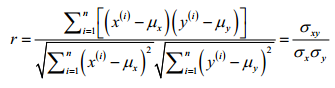

In [12]:
Image(filename='./images/10_21.png', width=400) 

여기서 $\mu$는 피처에 대한 샘플 평균, $\sigma_{xy}$은 피처 $x$와 $y$ 간의 공분산, 그리고 $\sigma_x$와 $\sigma_y$는 각각 피처의 표준편차를 가리킨다.

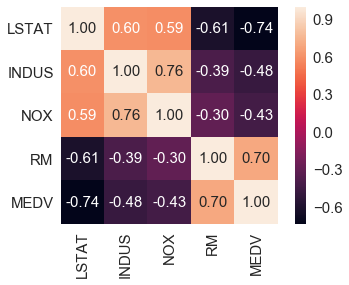

In [13]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

In [14]:
sns.reset_orig()
%matplotlib inline

<br>
<br>

# 10.3 Implementing an ordinary least squares linear regression model
# 순위형 최소 제곱 선형회귀 모델 구현

회귀선의 파라미터들의 추정하기 위해 샘플의 관측치들까지의 수직 거리의 제곱합을 최소화하는 순위형 최소제곱(Ordinary Least Square, OLE) 방법을 사용해서 퍼즐의 잃어버린 조각을 채워보도록 하자

## 10.3.1 Solving regression for regression parameters with gradient descent 
## 그래디언트 디센트를 갖는 회귀 파라미터를 위해 회귀 모델 풀기 

In [16]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [17]:
X = df[['RM']].values
y = df['MEDV'].values

In [18]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [19]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

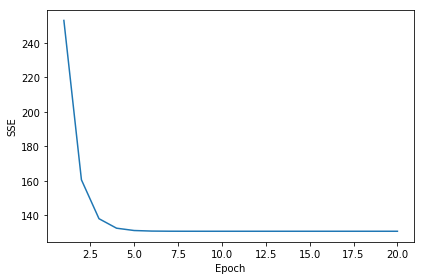

In [20]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

In [21]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

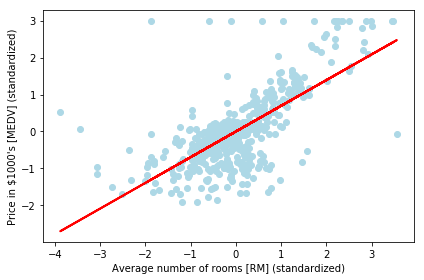

In [22]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

In [23]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [24]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


<br>
<br>

## 10.3.2 Estimating the coefficient of a regression model via scikit-learn
## 사이킷런을 활용한 회귀 모델 계수 추정

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


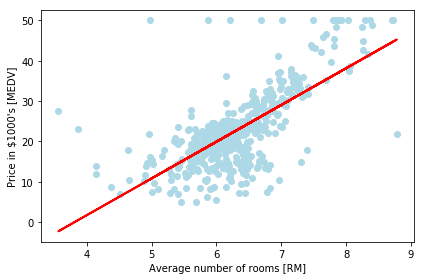

In [27]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

**Normal Equations** alternative:

In [28]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


<br>
<br>

# 10.4 Fitting a robust regression model using RANSAC
# RANSAC을 사용하는 강건한 회귀 모델 피팅

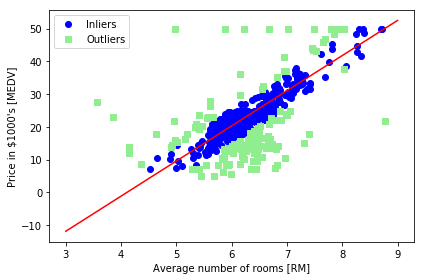

In [29]:
from sklearn.linear_model import RANSACRegressor

if Version(sklearn_version) < '0.18':
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                             residual_threshold=5.0, 
                             random_state=0)
else:
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             loss='absolute_loss', 
                             residual_threshold=5.0, 
                             random_state=0)


ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [30]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


<br>
<br>

# 10.5 Evaluating the performance of linear regression models 
# 선형회귀 모델의 성능 평가 

In [31]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [32]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

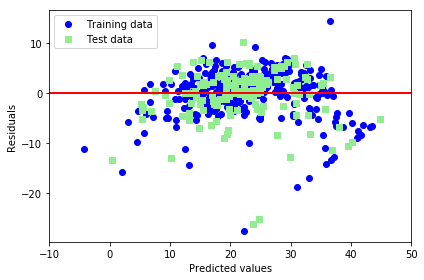

In [33]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

In [34]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


<br>
<br>

# 10.6 Using regularized methods for regression 
# 회귀를 위한 정규화 메서드 사용 

In [35]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [36]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


<br>
<br>

# 10.7 Turning a linear regression model into a curve - polynomial regression 
# 선형회귀 모델을 곡선의 다항 회귀로 변환하기 

In [37]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [38]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

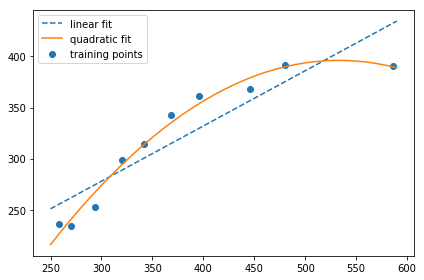

In [39]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

In [40]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [41]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


<br>
<br>

## 10.7.1 Modeling nonlinear relationships in the Housing Dataset 
## 하우징 데이터 내의 비선형관계 모델링 

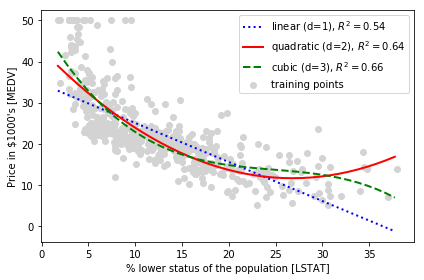

In [42]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

Transforming the dataset:

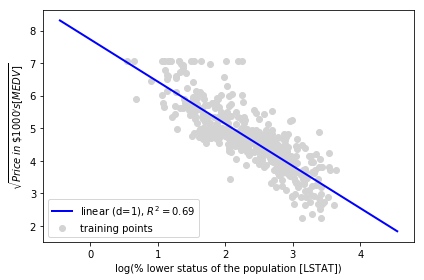

In [43]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

<br>
<br>

# 10.7.2 Dealing with nonlinear relationships using random forests
# 랜덤 포레스트를 사용하여 비선형관계 처리하기 

...

## 10.7.2.1 Decision tree regression 
## 의사결정나무 회귀 

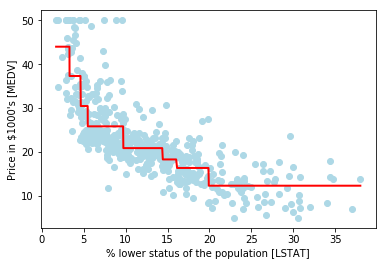

In [44]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

<br>
<br>

## 10.7.2.2 Random forest regression 
## 랜덤 포레스트 회귀 

In [45]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [46]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


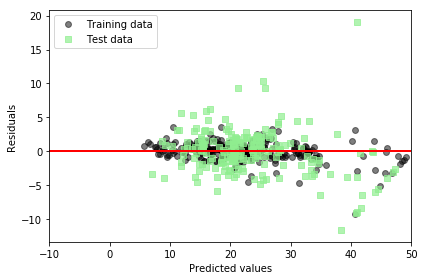

In [47]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

<br>
<br>

# 10.8 Summary

- 하나의 설명변수와 연속형 방응변수 간의 관계를 모델링하는 심플 선형회귀 모델의 사용에 대해 학습했다. 
- 데이터 내의 패턴과 이상치를 살펴보는 데 유용한 데이터 분석 기법에 대해 논의했다. 이것이 예측 모델링 작업에서 중요한 첫 번째 단계이다. 
- 첫 번째 모델은 그래디언트 기반의 최적화 방법을 사용하는 선형회귀를 구현하여 만들었다. 
- 회귀 모델에 대한 사이킷런 선형 모델을 활용하는 방법을 살펴보고 이상치를 처리하기 위한 한 가지 방법으로 RANSAC을 구현하기도 했다. 
- 회귀 모델의 예측 성능을 평가하기 위해 제곱 오차의 평균합과 이와 관련된 $R^2$을 계산했다. 
- 정규화를 회귀 모델에 적용하여 모델의 복잡도를 줄이고 오버피팅을 피하는 방법에 대해 논의했다. 
- 다항 특성 변환과 랜덤 포레스트 리그레서를 포함하여 비선형관계를 모델링하기 위한 여러 가지 방법도 소개했다. 